# Введение в Pytorch

## Часть 2 - предобработка данных, нейросети

Александр Дьяконов, 2020


c.135

#### использованные материалы

* https://github.com/MLWhiz/data_science_blogs/blob/master/pytorch_guide/Pytorch%20Guide.ipynb
* https://d2l.ai/
* https://atcold.github.io/pytorch-Deep-Learning/
* семинары OzonMasters
* https://habr.com/ru/post/334380/
* https://github.com/andriygav/MachineLearningSeminars/
* https://uvadlc-notebooks.readthedocs.io/en/latest/index.html

**Pytorch** - открытый фреймворк для построения и использования динамических графов вычислений и глубокого обучения. Есть альтернативы: [TensorFlow](https://www.tensorflow.org/), [JAX](https://github.com/google/jax#quickstart-colab-in-the-cloud) and [Caffe](http://caffe.berkeleyvision.org/). Изначально разрабатывался компанией Facebook. Основное преимущество - автоматическое дифференцирование.

In [ ]:
# from __future__ import print_function
import torch
import numpy as np

# что разумно сразу импортировать
from torch import nn
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision.transforms import ToTensor, Lambda, Compose
import matplotlib.pyplot as plt

In [ ]:
# служебная функция

from matplotlib import pyplot as plt

def plot_data(X, y, d=0, auto=False, zoom=1):
    X = X.cpu()
    y = y.cpu()
    plt.scatter(X.numpy()[:, 0], X.numpy()[:, 1], c=y, s=20, cmap=plt.cm.Spectral)
    plt.axis('square')
    plt.axis(np.array((-1.1, 1.1, -1.1, 1.1)) * zoom)
    if auto is True: plt.axis('equal')
    plt.axis('off')

    _m, _c = 0, '.15'
    plt.axvline(0, ymin=_m, color=_c, lw=1, zorder=0)
    plt.axhline(0, xmin=_m, color=_c, lw=1, zorder=0)

def plot_model(X, y, model):
    model.cpu()
    mesh = np.arange(-1.1, 1.1, 0.01)
    xx, yy = np.meshgrid(mesh, mesh)
    with torch.no_grad():
        data = torch.from_numpy(np.vstack((xx.reshape(-1), yy.reshape(-1))).T).float()
        Z = model(data).detach()
    Z = np.argmax(Z, axis=1).reshape(xx.shape)
    plt.contourf(xx, yy, Z, cmap=plt.cm.Spectral, alpha=0.3)
    plot_data(X, y)

## TensorDataset / DataLoader

организация подачи данных в модель

* TensorDataset - для представления датасета. Часто приходится определять свой датасет, наследуя этот класс.
* DataLoader - подаёт батчами данные, позволяется итерироваться по датасету, автоматически формируя батчи (и делая некоторые сопутствующие действия).


In [ ]:
from torch.utils.data import TensorDataset
import numpy as np

x = torch.from_numpy(np.vstack([np.arange(10, dtype='float32'), np.ones(10, dtype='float32')]).T)
y = torch.from_numpy(np.arange(10, dtype='float32')[:, np.newaxis] ** 2)

ds = TensorDataset(x, y)

from torch.utils.data import DataLoader

batch_size = 4
dl = DataLoader(ds, batch_size, shuffle=True)

for xb, yb in dl:
    print(xb)
    print(yb)
    # break

tensor([[3., 1.],
        [1., 1.],
        [0., 1.],
        [9., 1.]])
tensor([[ 9.],
        [ 1.],
        [ 0.],
        [81.]])
tensor([[5., 1.],
        [2., 1.],
        [6., 1.],
        [8., 1.]])
tensor([[25.],
        [ 4.],
        [36.],
        [64.]])
tensor([[7., 1.],
        [4., 1.]])
tensor([[49.],
        [16.]])


Есть много вспомогательных полезных функций. Например, можно разделить датасет на части.

In [ ]:
train_size = int(0.8 * len(ds))
test_size = len(ds) - train_size
train_dataset, test_dataset = torch.utils.data.random_split(ds, [train_size, test_size])

In [ ]:
for xb, yb in test_dataset:
  print (xb, yb)

tensor([2., 1.]) tensor([4.])
tensor([4., 1.]) tensor([16.])


In [ ]:
# список -> в нейронку

import torch
import numpy as np
from torch.utils.data import TensorDataset, DataLoader

my_x = [np.array([[1.0,2],[3,4]]),np.array([[5.,6],[7,8]])] # a list of numpy arrays
my_y = [np.array([4.]), np.array([2.])] # another list of numpy arrays (targets)

tensor_x = torch.Tensor(my_x) # transform to torch tensor
tensor_y = torch.Tensor(my_y)

my_dataset = TensorDataset(tensor_x,tensor_y) # create your datset
my_dataloader = DataLoader(my_dataset) # create your dataloader


# UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray

<ipython-input-11-0354a49779ff>:10: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:230.)
  tensor_x = torch.Tensor(my_x) # transform to torch tensor


Трансформации можно и нужно делать разные для обучения и теста

И тест не перемешиваем

Загрузчик данных обычно используют torch.utils.data.DataLoader - свой не пишут.

In [ ]:
# загрузка с трансформациями
from torchvision import datasets

train_loader = torch.utils.data.DataLoader(
    datasets.MNIST('../data', train=True, download=True,
                   transform=transforms.Compose([
                       transforms.ColorJitter(brightness=(0.6, 1), contrast=(0.8, 1)),
                       transforms.RandomRotation((-15, 15)),
                       transforms.ToTensor(), # перевод в тензор + нормировка на отрезок
                       transforms.Normalize((0.1307,), (0.3081,))
                   ])),
    batch_size=64, shuffle=True, num_workers=8, pin_memory=True)
# c num_workers лучше поэкспериментировать! Это число подпроцессов для загрузки данных.
# Чаще pin_memory=True если используем GPU. Предварительно копирует данные на GPU.

# transform_for_train =
# transform_for_val =
# drop_last - удалять ли последний батч, если его размер меньше остальных.

In [ ]:
# есть стандартные датасеты
trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)

training_data = datasets.FashionMNIST(root="data", train=True, download=True, transform=ToTensor())

In [ ]:
# загрузка из директории

traindir = "/home/rahul/projects/compvisblog/data/train/"
t = transforms.Compose([transforms.Resize(size=256),
                        transforms.CenterCrop(size=224),
                        transforms.ToTensor()])

train_dataset = torchvision.datasets.ImageFolder(root=traindir, transform=t)

for i in range(0,len(train_dataset)):
    image ,label = train_dataset[i]
    print(image,label)
    break

train_dataloader = DataLoader(train_dataset,batch_size = 64, shuffle=True, num_workers=10)
for image_batch, label_batch in train_dataloader:
    print(image_batch.size(),label_batch.size())
    break

In [ ]:
# все трансформации
from torchvision import transforms
dir(transforms)

['CenterCrop',
 'ColorJitter',
 'Compose',
 'FiveCrop',
 'Grayscale',
 'Lambda',
 'LinearTransformation',
 'Normalize',
 'Pad',
 'RandomAffine',
 'RandomApply',
 'RandomChoice',
 'RandomCrop',
 'RandomErasing',
 'RandomGrayscale',
 'RandomHorizontalFlip',
 'RandomOrder',
 'RandomPerspective',
 'RandomResizedCrop',
 'RandomRotation',
 'RandomSizedCrop',
 'RandomVerticalFlip',
 'Resize',
 'Scale',
 'TenCrop',
 'ToPILImage',
 'ToTensor',
 '__builtins__',
 '__cached__',
 '__doc__',
 '__file__',
 '__loader__',
 '__name__',
 '__package__',
 '__path__',
 '__spec__',
 'functional',
 'transforms']

In [ ]:
# своя трансформация

import torch
from torchvision import datasets
from torchvision.transforms import ToTensor, Lambda

ds = datasets.FashionMNIST(
    root="data",
    train=True,
    download=True,
    transform=ToTensor(),
    target_transform=Lambda(lambda y: torch.zeros(10, dtype=torch.float).scatter_(0, torch.tensor(y), value=1))
)

# тут трансформация таргета
# target_transform = Lambda(lambda y: torch.zeros(10, dtype=torch.float).scatter_(dim=0, index=torch.tensor(y), value=1))

In [ ]:
# своя трансформация
class Noise():
    """Adds gaussian noise to a tensor.

    Example:
        >>> transforms.Compose([
        >>>     transforms.ToTensor(),
        >>>     Noise(0.1, 0.05)),
        >>> ])

    """
    def __init__(self, mean, stddev):
        self.mean = mean
        self.stddev = stddev

    def __call__(self, tensor):
        noise = torch.zeros_like(tensor).normal_(self.mean, self.stddev)
        return tensor.add_(noise)

    def __repr__(self):
        repr = f"{self.__class__.__name__  }(mean={self.mean},sttdev={self.stddev})"
        return repr

custom_transform_pipeline = transforms.Compose([random_colour_transform, Noise(0.1, 0.05)])

#### Создание своего датасета

Для работы с датасетами спользуется **torch.utils.data**:

* **TensorDataset(tensors)** - Creates a dataset object from a tensor
* **ConcatDataset(datasets)** - Creates a dataset from multiple datasets
* **ChainDataset(datasets)** - Chains multiple IterableDatasets
* **Subset(dataset, indices)** - Creates a subset of a dataset from specified indices

Чтобы pytorch работал с датасетом, надо определить
* __getitem__
* __len__

при этом его следует организовать как класс, наследуя от **torch.utils.data.Dataset**.



In [ ]:
# Свой датасет
class CustomTextDataset(Dataset):
    '''
    Simple Dataset initializes with X and y vectors
    We start by sorting our X and y vectors by sequence lengths
    '''
    def __init__(self,X,y=None):
        self.data = list(zip(X,y))
        # Sort by length of first element in tuple
        self.data = sorted(self.data, key=lambda x: len(x[0]))

    def __len__(self):
        # raise NotImplementedError
        return len(self.data)

    def __getitem__(self, idx):
        # raise NotImplementedError
        return self.data[idx]

Есть ещё iterable-style dataset, он наследуется от **torch.utils.data.IterableDataset**,
нужно определить

* iter()

Применяется, когда запросы со случайной индексацией дороги / невозможны.

In [ ]:
# свой загрузчик данных
from glob import glob
from PIL import Image
from torch.utils.data import Dataset

class customImageFolderDataset(Dataset):
    """Custom Image Loader dataset."""
    def __init__(self, root, transform=None):
        """
        Args:
            root (string): Path to the images organized in a particular folder structure.
            transform: Any Pytorch transform to be applied
        """
        # Get all image paths from a directory
        self.image_paths = glob(f"{root}/*/*")
        # Get the labels from the image paths
        self.labels = [x.split("/")[-2] for x in self.image_paths]
        # Create a dictionary mapping each label to a index from 0 to len(classes).
        self.label_to_idx = {x:i for i,x in enumerate(set(self.labels))}
        self.transform = transform

    def __len__(self):
        # return length of dataset
        return len(self.image_paths)

    def __getitem__(self, idx):
        # open and send one image and label
        img_name = self.image_paths[idx]
        label = self.labels[idx]
        image = Image.open(img_name)
        if self.transform:
            image = self.transform(image)
        return image,self.label_to_idx[label]


# другой вариант
class ImageDirectoryDataset(torch.utils.data.Dataset):
    def __init__(path, pattern):
        self.paths = list(glob.glob(os.path.join(path, pattern)))

    def __len__(self):
        return len(self.paths)

    def __item__(self):
        path = random.choice(paths)
        return cv2.imread(path, 1)

### датасет с несколькими входами в сеть

In [ ]:
# если несколько входов в сеть

from torch.utils.data import DataLoader, Dataset

class TrainDataset(Dataset):
    def __init__(self, df, num_features, cat_features, labels):
        self.cont_values = df[num_features].values
        self.cate_values = df[cat_features].values
        self.labels = labels

    def __len__(self):
        return len(self.cont_values)

    def __getitem__(self, idx):
        cont_x = torch.FloatTensor(self.cont_values[idx])
        cate_x = torch.LongTensor(self.cate_values[idx])
        label = torch.tensor(self.labels[idx]).float()

        return cont_x, cate_x, label


class TestDataset(Dataset):
    def __init__(self, df, num_features, cat_features):
        self.cont_values = df[num_features].values
        self.cate_values = df[cat_features].values

    def __len__(self):
        return len(self.cont_values)

    def __getitem__(self, idx):
        cont_x = torch.FloatTensor(self.cont_values[idx])
        cate_x = torch.LongTensor(self.cate_values[idx])

        return cont_x, cate_x

В DataLoder может передаваться сэмплер...

* SequentialSampler(data_source) - amples data in sequence
* RandomSampler(data_source, replacement=False, num_samples=None, generator=None) - Samples data randomly
* SubsetRandomSampler(indices, generator=None) - Samples data randomly from a subset of the dataset
* WeightedRandomSampler(weights, num_samples, replacement=True, generator=None) - Samples randomly from a weighted distribution
* BatchSampler(sampler, batch_size, drop_last) - Returns a batch of samples
* distributed.DistributedSampler(dataset, num_replicas=None, rank=None, shuffle=True, seed=0) - Samples across distributed datasets

Подмножества датасета:

In [ ]:
# Подмножество датасета

import torchvision
import torch

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=None)

evens = list(range(0, len(trainset), 2))
odds = list(range(1, len(trainset), 2))
trainset_1 = torch.utils.data.Subset(trainset, evens)
trainset_2 = torch.utils.data.Subset(trainset, odds)

trainloader_1 = torch.utils.data.DataLoader(trainset_1, batch_size=4,
                                            shuffle=True, num_workers=2)
trainloader_2 = torch.utils.data.DataLoader(trainset_2, batch_size=4,
                                            shuffle=True, num_workers=2)

In [11]:
# Взять первый кусок датасета
import torch.utils.data as data_utils
indices = torch.arange(10000)
tr_10k = data_utils.Subset(tr, indices)

# Случайное разделение
part_tr = torch.utils.data.random_split(tr, [tr_split_len, len(tr)-tr_split_len])[0]

NameError: ignored

## Модуль nn

Упрощает создание нейронных сетей.

В модуле torch.nn.functional содержатся функции, используемые в Pytorch (СДЕЛАТЬ ОБЗОР).

In [ ]:
# пример простейшего линейного слоя - он есть в готовом виде - torch.nn.Linear

from torch import nn
model = nn.Linear(in_features=2,
                  out_features=1,
                  bias=True)
print(model.weight)
print(model.bias)
list(model.parameters())

# нейросеть зависит от параметров (parameters) или по-простому весов (weights)

Parameter containing:
tensor([[-0.0243, -0.1254]], requires_grad=True)
Parameter containing:
tensor([-0.4057], requires_grad=True)


[Parameter containing:
 tensor([[-0.0243, -0.1254]], requires_grad=True),
 Parameter containing:
 tensor([-0.4057], requires_grad=True)]

In [ ]:
# билинейный слой
model = nn.Bilinear(in1_features=2,
                    in2_features=3,
                    out_features=4,
                    bias=False)

x1 = torch.tensor([1., 2.])
x2 = torch.tensor([1., 2., 3.])
print (model(x1, x2))
list(model.parameters())

tensor([-2.3678,  0.1738, -1.1961,  1.0129], grad_fn=<ViewBackward>)


[Parameter containing:
 tensor([[[-0.2877, -0.2869, -0.1025],
          [-0.6741,  0.6554, -0.4120]],
 
         [[-0.1636,  0.3774, -0.6691],
          [ 0.1150,  0.6620, -0.2147]],
 
         [[ 0.5587,  0.4396, -0.0669],
          [-0.5875,  0.6531, -0.6451]],
 
         [[-0.1595,  0.4781, -0.1300],
          [-0.5449, -0.3186,  0.4951]]], requires_grad=True)]

### Модуль nn: как обучать сеть

* train() / eval() - какой режим использовать - влияет на BN и DO

Перенос data.to(device) здесь (перед подачей данных в модель), а не в Dataset, т.к. выгоднее переносить целым батчем.


In [ ]:
# ошибка НС

import torch.nn.functional as F

model(xb) # определена

loss_fn = F.mse_loss
loss = loss_fn(model(xb), yb)
print(loss)

In [ ]:
# оптимизатор

opt = torch.optim.SGD(model.parameters(), lr=1e-5) # не забывать скобки в model.parameters()

In [ ]:
# само обучение

optimizer.zero_grad() # = net.zero_grad()
output = net(x)
loss = criterion(output,y)
loss.backward()
optimizer.step()
print(loss)

In [ ]:
# валидация
model.eval() # переводим сеть в нужный режим -  меняет поведение forward() - влияет на DO, BN
with torch.no_grad(): # контекстный менеджер, в котором не вычисляются градиенты, даже у тензоров с requires_grad=True
    train, y_train = train_dataset.tensors
    # train, y_train = train.to(device), y_train.to(device)
    train_preds = model(train)
    train_loss = loss_fn(train_preds, y_train).item()


In [ ]:
# функция для обучения модели
def fit(num_epochs, model, loss_fn, opt, train_dl):

    # повторяем нужное число эпох
    for epoch in range(num_epochs):
        model.train() # перенести раньше, если не выходим из режима обучения
        for xb, yb in train_dl: # по батчам
            pred = model(xb) # прогнать прямой ход
            opt.zero_grad() # обнулить градиенты
            loss = loss_fn(pred, yb) # вычислить ошибку
            loss.backward() # обратный ход - вычислить градиенты
            opt.step() # изменить параметры
        if (epoch+1) % 10 == 0: # прогресс
            print('Epoch [{}/{}], Loss: {:.4f}'.format(epoch+1, num_epochs, loss.item()))

In [ ]:
fit(100, model, loss_fn, opt, train_dl)

Epoch [10/100], Loss: 19.5047
Epoch [20/100], Loss: 2674.4380
Epoch [30/100], Loss: 83.3502
Epoch [40/100], Loss: 185.8370
Epoch [50/100], Loss: 175.2909
Epoch [60/100], Loss: 54.3152
Epoch [70/100], Loss: 2347.3945
Epoch [80/100], Loss: 7.9410
Epoch [90/100], Loss: 182.1962
Epoch [100/100], Loss: 331.3730


### Модуль nn: простейшее задание нейронной сети

Эквивалентные формы:

* через nn.Sequential - просто указываем модули, которые выполняются последовательно

* наследуя от nn.Module и прописывая init и forward

* присоединение модулей с помощью .add_module


**forward** - главная ф-ия определяет прямой проход и, собственно, функционирование сети (обратный проход не прописывается отдельным методом). Но когда мы делаем прямой проход, то явно не вызываем метод forward, а используем имя НС: net(X) (т.к. до и после вызова неявно ещё кое-что выполняется, ex: _forward_pre_hooks).


In [ ]:
# через nn.Sequential
net = nn.Sequential(nn.Linear(10, 5),
                    nn.ReLU(),
                    nn.Linear(5, 2))

# через nn.Sequential, но с удобными именами
from collections import OrderedDict
net1 = nn.Sequential(OrderedDict([('hidden_linear', nn.Linear(10, 5)),
                                  ('hidden_activation', nn.ReLU()),
                                  ('output', nn.Linear(5, 2))]))

X = torch.rand(3, 10)
net(X)

tensor([[-0.2359,  0.1572],
        [-0.0946,  0.0312],
        [-0.2290,  0.0459]], grad_fn=<AddmmBackward>)

In [ ]:
# наследуя от nn.Module и прописывая __init__ и forward

import torch.nn.functional as F

class MLP(nn.Module):
    def __init__(self):
        # инициализация параметров
        super().__init__() # super(MLP, self).__init__() Обращение к инициализации родителя
        self.hidden = nn.Linear(10, 5)  # Hidden layer
        self.out = nn.Linear(5, 2)  # Output layer

    def forward(self, X):
        # как обрабатываются данные и получается ответ
        return self.out(F.relu(self.hidden(X)))

net2 = MLP()
net2(X)

tensor([[0.1106, 0.4401],
        [0.0353, 0.3156],
        [0.0837, 0.3661]], grad_fn=<AddmmBackward>)

In [ ]:
# присоединение модулей с помощью .add_module

class NNN(torch.nn.Module):
    def __init__(self):
        super(NNN, self).__init__()

        self.layers = torch.nn.Sequential()
        self.layers.add_module('lin1', torch.nn.Linear(10, 5))
        self.layers.add_module('relu1', torch.nn.ReLU())
        self.layers.add_module('lin2', torch.nn.Linear(5, 2))

    def forward(self, input):
        return self.layers(input)

net3 = NNN()
net3(X)

tensor([[0.2955, 0.0559],
        [0.2978, 0.0343],
        [0.3301, 0.0773]], grad_fn=<AddmmBackward>)

In [ ]:
net

Sequential(
  (0): Linear(in_features=10, out_features=5, bias=True)
  (1): ReLU()
  (2): Linear(in_features=5, out_features=2, bias=True)
)

In [ ]:
net2

MLP(
  (hidden): Linear(in_features=10, out_features=5, bias=True)
  (out): Linear(in_features=5, out_features=2, bias=True)
)

In [ ]:
net3

NNN(
  (layers): Sequential(
    (lin1): Linear(in_features=10, out_features=5, bias=True)
    (relu1): ReLU()
    (lin2): Linear(in_features=5, out_features=2, bias=True)
  )
)

### Модуль nn: доступ к параметрам НС

In [ ]:
net[0], net2.hidden, net3.layers.relu1

(Linear(in_features=10, out_features=5, bias=True),
 Linear(in_features=10, out_features=5, bias=True),
 ReLU())

In [ ]:
net.state_dict() # все параметры сети. Точнее не только параметры, но, например, текущие средние для BN.

OrderedDict([('0.weight',
              tensor([[-0.1661, -0.1646, -0.1480,  0.2944,  0.0798,  0.1780,  0.0677,  0.2321,
                       -0.2498,  0.2428],
                      [ 0.0149,  0.2513,  0.0943, -0.3056, -0.0971, -0.1602,  0.0558,  0.1670,
                       -0.2786,  0.3096],
                      [-0.1832, -0.0631,  0.0159, -0.0190, -0.2769, -0.0364, -0.2855,  0.0240,
                       -0.1494, -0.0300],
                      [ 0.1317, -0.0984,  0.3070, -0.1473, -0.0666,  0.1092, -0.2754, -0.0981,
                        0.0684, -0.1167],
                      [ 0.1706, -0.2755,  0.3033, -0.1257, -0.2417, -0.3141, -0.2600, -0.3091,
                       -0.0552, -0.1265]])),
             ('0.bias', tensor([ 0.1352, -0.0321,  0.1371, -0.2746,  0.0892])),
             ('2.weight',
              tensor([[ 0.0051,  0.3829, -0.1443, -0.0035, -0.2843],
                      [ 0.2041, -0.2619,  0.3165,  0.3838, -0.1594]])),
             ('2.bias', tensor([-0.2393

In [ ]:
net[0].state_dict(), net2.hidden.state_dict() # параметры из слоёв

(OrderedDict([('weight',
               tensor([[-0.2112,  0.1398,  0.0284,  0.0310, -0.0959,  0.0015, -0.0984,  0.0909,
                         0.3071,  0.0479],
                       [-0.1401, -0.1932,  0.0242, -0.2346, -0.2377, -0.2058, -0.1074,  0.0234,
                         0.2178,  0.1225],
                       [ 0.2423, -0.1986,  0.0267, -0.2811,  0.1814,  0.0659,  0.3059, -0.2249,
                         0.2536,  0.2670],
                       [ 0.2557,  0.0451,  0.2875,  0.2112,  0.2359, -0.0205, -0.2427, -0.0039,
                         0.0593, -0.2154],
                       [-0.1814, -0.3032, -0.1109,  0.2755,  0.0541, -0.0193,  0.0127,  0.1972,
                        -0.2792, -0.2440]])),
              ('bias',
               tensor([-0.1051, -0.1820,  0.1631,  0.2234, -0.3068]))]),
 OrderedDict([('weight',
               tensor([[-0.2472,  0.0897,  0.0079, -0.2182,  0.1190, -0.0064, -0.3058,  0.1701,
                         0.1691, -0.0596],
                 

In [ ]:
net[0].bias.data, net2.hidden.bias.data

(tensor([-0.1051, -0.1820,  0.1631,  0.2234, -0.3068]),
 tensor([ 0.3139, -0.1659, -0.0243,  0.2580,  0.1043]))

In [ ]:
net[0].bias.grad, net2.hidden.bias.grad # не было обучения (BP), поэтому None

(None, None)

In [ ]:
# перечислить параметры - а вот тут уже параметры-тензоры!
print(*[(name, param.shape) for name, param in net.named_parameters()])

for param in net.parameters():
    print(param[:3])

('0.weight', torch.Size([5, 10])) ('0.bias', torch.Size([5])) ('2.weight', torch.Size([2, 5])) ('2.bias', torch.Size([2]))
tensor([[-0.2112,  0.1398,  0.0284,  0.0310, -0.0959,  0.0015, -0.0984,  0.0909,
          0.3071,  0.0479],
        [-0.1401, -0.1932,  0.0242, -0.2346, -0.2377, -0.2058, -0.1074,  0.0234,
          0.2178,  0.1225],
        [ 0.2423, -0.1986,  0.0267, -0.2811,  0.1814,  0.0659,  0.3059, -0.2249,
          0.2536,  0.2670]], grad_fn=<SliceBackward>)
tensor([-0.1051, -0.1820,  0.1631], grad_fn=<SliceBackward>)
tensor([[-0.3795, -0.4355,  0.1687,  0.3599, -0.3467],
        [-0.2070,  0.1423, -0.2920,  0.3799,  0.1043]],
       grad_fn=<SliceBackward>)
tensor([-0.1245,  0.0290], grad_fn=<SliceBackward>)


In [ ]:
# считаем число параметров
numel_list = [p.numel() for p in net.parameters() if p.requires_grad == True] # число обучаемых параметров!
sum(numel_list), numel_list

# pytorch_total_params = sum(p.numel() for p in model.parameters()) # число параметров
# pytorch_total_params = sum(p.numel() for p in model.parameters() if p.requires_grad)  # число обучаемых параметров

(67, [50, 5, 10, 2])

In [ ]:
# вывод размеров по слоям

# X = torch.rand(size=(1, 1, 28, 28), dtype=torch.float32)
X = torch.rand(size=(20, 10), dtype=torch.float32)

for layer in net:
    X = layer(X)
    print(layer.__class__.__name__,'output shape: \t',X.shape)

Linear output shape: 	 torch.Size([20, 5])
ReLU output shape: 	 torch.Size([20, 5])
Linear output shape: 	 torch.Size([20, 2])


In [ ]:
# Вывод параметров через state_dict
for param_tensor in net.state_dict():
    print(param_tensor, "\t", net.state_dict()[param_tensor].size())

Model's state_dict:
0.weight 	 torch.Size([5, 10])
0.bias 	 torch.Size([5])
2.weight 	 torch.Size([2, 5])
2.bias 	 torch.Size([2])



## Ещё примеры заданий нейросетей

При инициализации обычно прописываются параметры сети, если их надо задавать явно, то используется **nn.Parameter**.

In [ ]:
class myCrazyNeuralNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.lin1 = nn.Linear(784, 30)
        self.lin2 = nn.Linear(30, 784)
        self.lin3 = nn.Linear(30, 10)

    def forward(self, x):
        x_lin1 = self.lin1(x)
        x_lin2 = x + self.lin2(x_lin1)
        x_lin2 = self.lin1(x_lin2)
        x = self.lin3(x_lin2)
        return x

In [ ]:
# удобная универсальная конструкция
# ПЕРЕПИСАТЬ

def conv_block(in_f, out_f, activation='relu', *args, **kwargs):
    activations = nn.ModuleDict([
                ['lrelu', nn.LeakyReLU()],
                ['relu', nn.ReLU()]
    ])

    return nn.Sequential(
        nn.Conv2d(in_f, out_f, *args, **kwargs),
        nn.BatchNorm2d(out_f),
        activations[activation]
    )

def dec_block(in_f, out_f):
    return nn.Sequential(
        nn.Linear(in_f, out_f),
        nn.Sigmoid()
    )

class MyEncoder(nn.Module):
    def __init__(self, enc_sizes, *args, **kwargs):
        super().__init__()
        self.conv_blokcs = nn.Sequential(*[conv_block(in_f, out_f, kernel_size=3, padding=1, *args, **kwargs)
                       for in_f, out_f in zip(enc_sizes, enc_sizes[1:])])

        def forward(self, x):
            return self.conv_blokcs(x)

class MyDecoder(nn.Module):
    def __init__(self, dec_sizes, n_classes):
        super().__init__()
        self.dec_blocks = nn.Sequential(*[dec_block(in_f, out_f)
                       for in_f, out_f in zip(dec_sizes, dec_sizes[1:])])
        self.last = nn.Linear(dec_sizes[-1], n_classes)

    def forward(self, x):
        return self.dec_blocks()


class MyCNNClassifier(nn.Module):
    def __init__(self, in_c, enc_sizes, dec_sizes,  n_classes, activation='relu'):
        super().__init__()
        self.enc_sizes = [in_c, *enc_sizes]
        self.dec_sizes = [32 * 28 * 28, *dec_sizes]

        self.encoder = MyEncoder(self.enc_sizes, activation=activation)

        self.decoder = MyDecoder(dec_sizes, n_classes)

    def forward(self, x):
        x = self.encoder(x)

        x = x.flatten(1) # flat

        x = self.decoder(x)

        return x

In [ ]:
# явное прописывание весов

class MyNetworkWithParams(nn.Module): # Module - удобная сущность для определения НС
    def __init__(self,input_size, hidden_size, output_size):
        super(MyNetworkWithParams,self).__init__()
        self.layer1_weights = nn.Parameter(torch.randn(input_size, hidden_size)) # параметр автоматически регистрируется как параметр модуля
        self.layer1_bias = nn.Parameter(torch.randn(hidden_size))
        self.layer2_weights = nn.Parameter(torch.randn(hidden_size, output_size))
        self.layer2_bias = nn.Parameter(torch.randn(output_size))

    def forward(self,x):
        h1 = torch.matmul(x,self.layer1_weights) + self.layer1_bias
        h1_act = torch.max(h1, torch.zeros(h1.size())) # ReLU
        output = torch.matmul(h1_act,self.layer2_weights) + self.layer2_bias
        return output

net = MyNetworkWithParams(32, 128, 10)

In [ ]:
# перечислим параметры
for name, x in net.state_dict().items():
    print (name, x.shape)

layer1_weights torch.Size([32, 128])
layer1_bias torch.Size([128])
layer2_weights torch.Size([128, 10])
layer2_bias torch.Size([10])


In [ ]:
# вложенные модули (блоки)

def block1():
    # здесь реализуем базовый строительный блок
    return nn.Sequential(nn.Linear(10, 4), nn.ReLU(),
                         nn.Linear(4, 10), nn.ReLU())

def block2():
    net = nn.Sequential()
    for i in range(4):
        # здесь присоединяем базовый блок к нашей сети
        net.add_module(f'block {i}', block1())
    return net

rgnet = nn.Sequential(block2(), nn.Linear(10, 1))

rgnet(X)

print(rgnet)

Sequential(
  (0): Sequential(
    (block 0): Sequential(
      (0): Linear(in_features=10, out_features=4, bias=True)
      (1): ReLU()
      (2): Linear(in_features=4, out_features=10, bias=True)
      (3): ReLU()
    )
    (block 1): Sequential(
      (0): Linear(in_features=10, out_features=4, bias=True)
      (1): ReLU()
      (2): Linear(in_features=4, out_features=10, bias=True)
      (3): ReLU()
    )
    (block 2): Sequential(
      (0): Linear(in_features=10, out_features=4, bias=True)
      (1): ReLU()
      (2): Linear(in_features=4, out_features=10, bias=True)
      (3): ReLU()
    )
    (block 3): Sequential(
      (0): Linear(in_features=10, out_features=4, bias=True)
      (1): ReLU()
      (2): Linear(in_features=4, out_features=10, bias=True)
      (3): ReLU()
    )
  )
  (1): Linear(in_features=10, out_features=1, bias=True)
)


In [ ]:
rgnet[0][2][2].bias

Parameter containing:
tensor([ 0.2119,  0.1545, -0.0612,  0.2647, -0.3946, -0.0332, -0.0323,  0.3765,
        -0.1765, -0.4842], requires_grad=True)

In [ ]:
# эффективное задание многослойного персептрона

class MLP(nn.Module):

    def __init__(self, input_dims=64, hidden_dims=[128, 256], output_dims=10):
        super().__init__()
        hidden_dims = [input_dims] + hidden_dims
        layers = []
        for i in range(len(hidden_dims)-1):
            layers += [
                nn.Linear(hidden_dims[i], hidden_dims[i+1]),
                nn.ReLU(inplace=True)
            ]
        layers += [nn.Linear(hidden_dims[-1], output_dims)]
        self.layers = nn.Sequential(*layers)

    def forward(self, x):
        return self.layers(x)

net = MLP(2, [4, 6], 10)

net

MLP(
  (layers): Sequential(
    (0): Linear(in_features=2, out_features=4, bias=True)
    (1): ReLU(inplace=True)
    (2): Linear(in_features=4, out_features=6, bias=True)
    (3): ReLU(inplace=True)
    (4): Linear(in_features=6, out_features=10, bias=True)
  )
)

## Разделение параметров

In [ ]:
shared = nn.Linear(8, 8)
net = nn.Sequential(nn.Linear(4, 8), nn.ReLU(),
                    shared, nn.ReLU(),
                    shared, nn.ReLU(),
                    nn.Linear(8, 1))

### сеть с несколькими входами

In [10]:
import torch
from torch import nn

class TwoInputsNet(nn.Module):
  def __init__(self):
    super(TwoInputsNet, self).__init__()
    self.conv = nn.Conv2d( ... )  # set up your layer here
    self.fc1 = nn.Linear( ... )  # set up first FC layer
    self.fc2 = nn.Linear( ... )  # set up the other FC layer

  def forward(self, input1, input2):
    c = self.conv(input1)
    f = self.fc1(input2)
    # now we can reshape `c` and `f` to 2D and concat them
    combined = torch.cat((c.view(c.size(0), -1),
                          f.view(f.size(0), -1)), dim=1)
    out = self.fc2(combined)
    return out

## Свои модули (слои), задание модулей

По сути, это маленькая НС

* пример слоя
* слой + NN
* списки слоёв

Слой надо задавать на базе nn.Module
* есть список слоёв - nn.ModuleList
* есть словарь - nn.ModuleDict

In [ ]:
# центрирующий слой без параметров

class CenteredLayer(nn.Module):
    def __init__(self):
        super().__init__()

    def forward(self, X):
        return X - X.mean()

In [ ]:
from torch import nn

class myCustomLinearLayer(nn.Module):
    def __init__(self, in_size, out_size):
        super().__init__()
        self.weights = nn.Parameter(torch.randn(in_size, out_size))
        self.bias = nn.Parameter(torch.zeros(out_size))

    def forward(self, x):
        return x.mm(self.weights) + self.bias

class myCustomNeuralNet(nn.Module):
    def __init__(self):
        super().__init__()
        # Define all Layers Here
        self.lin1 = myCustomLinearLayer(784, 10)

    def forward(self, x):
        # Connect the layer Outputs here to define the forward pass
        x = self.lin1(x)
        return x

x = torch.randn((100, 784))
model = myCustomNeuralNet()
model(x).size()

torch.Size([100, 10])

In [ ]:
# чуть по-другому линейный слой

import torch.nn as nn
from torch import Tensor
import math

class MyLinear(nn.Module):
    """
    линейный слой
    """

    def __init__(self, in_features, out_features, bias): # <1>
        super(MyLinear, self).__init__()
        self.in_features = in_features
        self.out_features = out_features
        self.weight = nn.Parameter(
            torch.Tensor(out_features,
                         in_features))
        if bias:
            self.bias = nn.Parameter(
                torch.Tensor(out_features))
        else:
            self.register_parameter('bias', None)
        self.reset_parameters()

    def reset_parameters(self):
        nn.init.kaiming_uniform_(self.weight,
                              a=math.sqrt(5))
        if self.bias is not None:
            fan_in, _ = \
              nn.init._calculate_fan_in_and_fan_out(
                  self.weight)
            bound = 1 / math.sqrt(fan_in)
            init.uniform_(self.bias, -bound, bound)

    def forward(self, input: Tensor) -> Tensor: # <2>
        return F.linear(input,
                        self.weight,
                        self.bias) # <3>

net = MyLinear(2, 3, False)

net.state_dict()

OrderedDict([('weight',
              tensor([[-0.5998, -0.1427],
                      [-0.2735,  0.4950],
                      [ 0.0721, -0.1688]]))])

In [ ]:
# списки слоёв

class MyNet(nn.Module):
    def __init__(self,n_hidden_layers):
        super(MyNet,self).__init__()
        self.n_hidden_layers = n_hidden_layers
        self.final_layer = nn.Linear(128, 10)
        self.act = nn.ReLU()
        self.hidden = []
        for i in range(n_hidden_layers):
            self.hidden.append(nn.Linear(128, 128))
        self.hidden = nn.ModuleList(self.hidden) # это важно!

    def forward(self,x):
        h = x
        for i in range(self.n_hidden_layers):
            h = self.hidden[i](h)
            h = self.act(h)
        out = self.final_layer(h)
        return out

In [ ]:
# свой "нормализатор" [NEW]

import torch
import torch.nn as nn
from torchvision.models import resnet50

# пример модуля для нормализации
class Normalize(nn.Module):
    def __init__(self, mean, std):
        super(Normalize, self).__init__()
        self.mean = torch.Tensor(mean)
        self.std = torch.Tensor(std)
    def forward(self, x):
        return (x - self.mean.type_as(x)[None,:,None,None]) / self.std.type_as(x)[None,:,None,None]

# для нормализации ImageNet images, см. https://github.com/pytorch/examples/blob/master/imagenet/main.py
norm = Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])

# загружаем предобученную сеть
model = resnet50(pretrained=True)
model.eval();

# даём на вход нормализованное изображение
pred = model(norm(pig_tensor))

## Инициализация

In [ ]:
# инициализация
import torch.nn as nn
import torch

def init_normal(m):
    if type(m) == nn.Linear:
        nn.init.normal_(m.weight, mean=0, std=0.01)
        nn.init.zeros_(m.bias)

def init_normal_v2(m):
    if isinstance(m, nn.Linear):
        torch.nn.init.xavier_uniform_(m.weight)
        m.bias.data.fill_(0.01)

net = nn.Sequential(nn.Linear(2, 2), nn.Linear(2, 2))
net.apply(init_normal)

print (net[0].weight.data[0], net[0].bias.data[0])

net.apply(init_normal_v2)

print (net[0].weight.data[0], net[0].bias.data[0])

tensor([-0.0013,  0.0183]) tensor(0.)
tensor([ 0.5608, -0.1452]) tensor(0.0100)


In [ ]:
# способ, где копируются веса в нужное место

def init_custom(m):
    if type(m) == nn.Linear:
        rw = torch.randn(m.weight.data.size())
        m.weight.data.copy_(rw)

In [ ]:
# инициализация по блокам

def xavier(m):
    if type(m) == nn.Linear:
        nn.init.xavier_uniform_(m.weight)

def init_42(m):
    if type(m) == nn.Linear:
        nn.init.constant_(m.weight, 42)

net[0].apply(xavier)
net[2].apply(init_42)

print(net[0].weight.data[0])
print(net[2].weight.data)

tensor([-0.3876,  0.1836,  0.5121, -0.5632,  0.3504,  0.0779, -0.6140, -0.2752,
        -0.0533, -0.3310])
tensor([[42., 42., 42., 42., 42.],
        [42., 42., 42., 42., 42.]])


In [ ]:
# пример инициализации из DCGAN
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

## Функции обучения и теста на одной эпохе

сейчас рекомендуется заменять **torch.no_grad()** на **torch.inference_mode()**

In [ ]:
# простое обучение (без формальной НС)

# данные
x, y = [1.0, 2.0, 3.0, 4.0, 5.0], [2.0, 4.0, 6.0, 8.0, 10.0]
w = torch.tensor([1.0], requires_grad=True) # веса

def forward(x):
    return x * w

def loss(y_pred, y_val):
    return (y_pred - y_val) ** 2

# обучение
for epoch in range(2):
    for x_, y_ in zip(x, y):
        a = forward(x_) # Forward
        l = loss(a, y_) # Loss
        l.backward() # Back propagation
        print("\tgrad: ", x_, y_, a.item(), w.grad.item())
        w.data = w.data - 0.01 * w.grad.item() # ~ update weights
        w.grad.data.zero_() # zero weights

    print(f"Epoch: {epoch} | Loss: {l.item()}")

	grad:  1.0 2.0 1.0 -2.0
	grad:  2.0 4.0 2.0399999618530273 -7.840000152587891
	grad:  3.0 6.0 3.2951998710632324 -16.228801727294922
	grad:  4.0 8.0 5.042752265930176 -23.657981872558594
	grad:  5.0 10.0 7.486339092254639 -25.136608123779297
Epoch: 0 | Loss: 6.318490982055664
	grad:  1.0 2.0 1.748633861541748 -0.5027322769165039
	grad:  2.0 4.0 3.507322311401367 -1.9707107543945312
	grad:  3.0 6.0 5.320104598999023 -4.079372406005859
	grad:  4.0 8.0 7.256648063659668 -5.946815490722656
	grad:  5.0 10.0 9.36815071105957 -6.318492889404297
Epoch: 1 | Loss: 0.39923352003097534


In [ ]:
# Обучение с сетью

x = [torch.tensor([[x_]]) for x_ in x]
y = [torch.tensor([[y_]]) for y_ in y]

class Model(nn.Module):
    def __init__(self):
        super(Model, self).__init__()
        self.linear = torch.nn.Linear(1, 1)

    def forward(self, x):
          return self.linear(x)

model = Model()

criterion = torch.nn.MSELoss(reduction='sum')
optimizer = torch.optim.SGD(model.parameters(), lr=0.01)

for epoch in range(2):
    for x_, y_ in zip(x, y):
        a = model(x_)
        loss = criterion(a, y_)# Loss
        print(f'Epoch: {epoch} | Loss: {loss.item()} ')
        optimizer.zero_grad() # Zero
        loss.backward() # BW
        optimizer.step() # opt

# после обучения
y_pred = model(torch.tensor([[4.0]]))

Epoch: 0 | Loss: 5.618300914764404 
Epoch: 0 | Loss: 20.990278244018555 
Epoch: 0 | Loss: 39.01418685913086 
Epoch: 0 | Loss: 45.49380111694336 
Epoch: 0 | Loss: 32.03615951538086 
Epoch: 1 | Loss: 0.02166941575706005 
Epoch: 1 | Loss: 0.6096134185791016 
Epoch: 1 | Loss: 1.7185356616973877 
Epoch: 1 | Loss: 2.4910850524902344 
Epoch: 1 | Loss: 2.0880186557769775 


In [ ]:
def train_epoch(model, train_loader, criterion, optimizer):
    model.train()

    running_loss = 0.0

    start_time = time.time()
    for batch_idx, (data, target) in enumerate(train_loader):
        optimizer.zero_grad(set_to_none=True)   # .backward() accumulates gradients, это эквивалентно model.zero_grad()
        data = data.to(device)
        target = target.to(device) # перенос на device

        outputs = model(data)
        loss = criterion(outputs, target)
        running_loss += loss.item()

        loss.backward()
        optimizer.step()

    end_time = time.time()

    running_loss /= len(train_loader)
    print('Training Loss: ', running_loss, 'Time: ',end_time - start_time, 's')
    return running_loss

def test_model(model, test_loader, criterion):
    with torch.no_grad(): # не забывать делать это и на Inference
        model.eval()

        running_loss = 0.0
        total_predictions = 0.0
        correct_predictions = 0.0

        for batch_idx, (data, target) in enumerate(test_loader):
            data = data.to(device)
            target = target.to(device)

            outputs = model(data)

            _, predicted = torch.max(outputs.data, 1)
            total_predictions += target.size(0)
            correct_predictions += (predicted == target).sum().item()

            loss = criterion(outputs, target).detach()
            running_loss += loss.item()


        running_loss /= len(test_loader)
        acc = (correct_predictions/total_predictions)*100.0
        print('Testing Loss: ', running_loss)
        print('Testing Accuracy: ', acc, '%')
        return running_loss, acc

n_epochs = 10
Train_loss = []
Test_loss = []
Test_acc = []

for i in range(n_epochs):
    train_loss = train_epoch(model, train_loader, criterion, optimizer)
    test_loss, test_acc = test_model(model, test_loader, criterion)
    Train_loss.append(train_loss)
    Test_loss.append(test_loss)
    Test_acc.append(test_acc)
    print('='*20)

ещё подобная функция

In [ ]:
#основная функция для обучения сети
# !!! тут нет функции evaluate_net

def train_net(n_epochs, net, optimizer, criterion, trainloader, testloader, use_cuda=True, verbose=True):

    if use_cuda:
        net = net.cuda()

    net = net.train()

    # основной цикл по всем эпохам
    for epoch in range(n_epochs):
        running_loss = 0.0

        # цикл по батчам внутри эпохи
        for data in trainloader:
            # берем очередной батч и его лейблы
            inputs, labels = data

            if use_cuda:
                inputs = inputs.cuda()
                labels = labels.cuda()

            # всегда перед вычислением градиентов зануляем их, чтобы не накапливались
            optimizer.zero_grad()

            # получили выход сетки
            outputs = net(inputs)

            # посчитали для этого выхода лосс
            loss = criterion(outputs, labels)

            # вычислили градиенты loss по параметрам сети (w)
            loss.backward()

            #далем шаг по антиградиенту - обновляем веса сети
            optimizer.step()

            #суммируемый лосс на обучении
            running_loss += float(loss) # loss.item()

        # логируем после каждой эпохи
        if verbose:
            test_loss, test_accuracy = evaluate_net(net, testloader, use_cuda=use_cuda)
            print('Epoch {}. Train_loss: {:.3f}' .format(epoch + 1, running_loss / len(trainloader)))
            print('Test_accuracy: {:.3f}, test_loss: {:.3f}' .format(test_accuracy, test_loss))
            print('------------------------------')

    if verbose:
        print('Finished Training')

In [ ]:
# Хак
# вместо обнуления градиента рекомендуют
for param in model.parameters():
    param.grad = None

# или в Pytorch, начиная с 1.7
optimizer.zero_grad(set_to_none=True)

### Валидация

In [ ]:
from torch.utils.data import random_split
# делим данные на две части 40к + 10к
train_set, val_set = random_split(train_data, [40000, 10000])
trainloader = torch.utils.data.DataLoader(train_set,
                                          batch_size=16,
                                          shuffle=True)
valloader = torch.utils.data.DataLoader(val_set,
                                        batch_size=16,
                                        shuffle=True)
print(len(trainloader)) # 2500
print(len(valloader)) # 625

## темп обучения, программы изменнения темпов

In [ ]:
# свой темп для каждого слоя

from torch import optim

optim.SGD([
    {'params': model.features.parameters()},
    {'params': model.classifier.parameters(), 'lr': 1e-3}
    ], lr=1e-2, momentum=0.9)




In [ ]:
# ещё пример - разные LR для разных слоёв

from torch.optim import Adam

model = Net()

optim = Adam(
    [
        {"params": model.fc.parameters(), "lr": 1e-3},
        {"params": model.agroupoflayer.parameters()},
        {"params": model.lastlayer.parameters(), "lr": 4e-2},
    ],
    lr=5e-4,
)

# оптимизтируются только перечисленные параметры

In [ ]:
from torch.optim.lr_scheduler import StepLR, ReduceLROnPlateau, CosineAnnealingLR


net = EasyCNN(n_classes=67)
net = net.cuda()

lr = 0.01
num_epochs = 5

optimizer = optim.SGD(net.parameters(), lr) # сообщаем параметры оптимизатору!
# сообщаем оптимизатор "шедьюлеру"
scheduler_1 = ReduceLROnPlateau(optimizer, factor=0.1, patience=1, threshold=0.1)
scheduler_2 = StepLR(optimizer, step_size=1, gamma=0.1) # умножаем на gamma через каждые step_size шагов

# впишем ReduceLROnPlateau в процесс обучения
def run_epoch(epoch, is_train):
    if is_train:
        net.train()
        loader = trainloader
        print("Training epoch: ", epoch + 1, "/", num_epochs)
    else:
        net.eval()
        loader = valloader
        print('Validation')

    running_loss = 0.0
    correct = 0.0
    total = 0.0

    for i, data in enumerate(loader):
        images, labels, _= data
        images, labels = images.cuda(), labels.cuda()
        outputs = net(images)
        loss = criterion(outputs, labels)

        if is_train:
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

        running_loss += loss.item()
        total += images.data.size(0)


        _, predicted = torch.max(outputs.data, 1)
        correct += (predicted == labels.data).sum()

    lr = scheduler_1.optimizer.param_groups[0]['lr']
    print('Loss: {:.3f}, accuracy: {:.3f}, lr: {}'.format(running_loss / (i + 1), correct / total * 100.0, lr))

    # шаг на эпоху должен быть один, сделаем его после валидации
    if not is_train:
        scheduler_1.step(running_loss / (i + 1))
        scheduler_2.step()


%%time
for epoch in range(num_epochs):
    #training
    run_epoch(epoch, is_train=True)

    #validation
    with torch.no_grad():
        run_epoch(epoch, is_train=False)

In [ ]:
# параметры оптимизатора (2DO: сделать вывод)
for var_name in optimizer.state_dict():
    print(var_name, "\t", optimizer.state_dict()[var_name])

### Свой оптимизатор

In [ ]:
class OptimizerTemplate:

    def __init__(self, params, lr):
        self.params = list(params)
        self.lr = lr

    def zero_grad(self):
        ## Set gradients of all parameters to zero
        for p in self.params:
            if p.grad is not None:
                p.grad.detach_() # For second-order optimizers important
                p.grad.zero_()

    @torch.no_grad()
    def step(self):
        ## Apply update step to all parameters
        for p in self.params:
            if p.grad is None: # We skip parameters without any gradients
                continue
            self.update_param(p)

    def update_param(self, p):
        # To be implemented in optimizer-specific classes
        raise NotImplementedError


class SGD(OptimizerTemplate):

    def __init__(self, params, lr):
        super().__init__(params, lr)

    def update_param(self, p):
        p_update = -self.lr * p.grad
        p.add_(p_update) # In-place update => saves memory and does not create computation graph

class Adam(OptimizerTemplate):

    def __init__(self, params, lr, beta1=0.9, beta2=0.999, eps=1e-8):
        super().__init__(params, lr)
        self.beta1 = beta1
        self.beta2 = beta2
        self.eps = eps
        self.param_step = {p: 0 for p in self.params} # Remembers "t" for each parameter for bias correction
        self.param_momentum = {p: torch.zeros_like(p.data) for p in self.params}
        self.param_2nd_momentum = {p: torch.zeros_like(p.data) for p in self.params}

    def update_param(self, p):
        self.param_step[p] += 1

        self.param_momentum[p] = (1 - self.beta1) * p.grad + self.beta1 * self.param_momentum[p]
        self.param_2nd_momentum[p] = (1 - self.beta2) * (p.grad)**2 + self.beta2 * self.param_2nd_momentum[p]

        bias_correction_1 = 1 - self.beta1 ** self.param_step[p]
        bias_correction_2 = 1 - self.beta2 ** self.param_step[p]

        p_2nd_mom = self.param_2nd_momentum[p] / bias_correction_2
        p_mom = self.param_momentum[p] / bias_correction_1
        p_lr = self.lr / (torch.sqrt(p_2nd_mom) + self.eps)
        p_update = -p_lr * p_mom

        p.add_(p_update)

In [ ]:
# ПРОСТО ЕЩЁ ОДИН ОПТИМИЗАТОР
# чуть-чуть по-другому написан

from collections import defaultdict

class Optimizer(object):

    def __init__(self, params, defaults):
        self.defaults = defaults
        self.state = defaultdict(dict) # параметры оптимизатора (хранит информацию между шагами)
        self.param_groups = [] # параметры сети

        param_groups = list(params)
        if len(param_groups) == 0:
            raise ValueError(
                """optimizer got an
                empty parameter list""")
        if not isinstance(param_groups[0], dict):
            param_groups = [{'params': param_groups}]

        for param_group in param_groups:
            self.add_param_group(param_group)

    def __getstate__(self):
        return {
            'defaults': self.defaults,
            'state': self.state,
            'param_groups': self.param_groups,
        }

    def __setstate__(self, state):
        self.__dict__.update(state)

    def zero_grad(self): # обнуление градиента
        r"""Clears the gradients of all
        optimized :class:`torch.Tensor` s."""

        for group in self.param_groups:
            for p in group['params']:
                if p.grad is not None:
                    p.grad.detach_()
                    p.grad.zero_()

    def step(self, closure): # выполнить шаг оптимизатора
        raise NotImplementedError




from torch.optim import Optimizer

class SimpleSGD(Optimizer):

    def __init__(self, params, lr='required'):
        if lr is not 'required' and lr < 0.0:
            raise ValueError("Invalid learning rate: {}".format(lr))

        defaults = dict(lr=lr)
        super(SimpleSGD, self).__init__(
            params, defaults)

    def step(self):
        for group in self.param_groups:
            for p in group['params']:
                if p.grad is None:
                    continue
                d_p = p.grad
                p.add_(d_p, alpha=-group['lr'])

        return

## Сохранение / загрузка сети

In [ ]:
torch.save(model, "/tmp/model.pth")
torch.save(model.state_dict(), "/tmp/model.pth") # только параметры

model = torch.load("/tmp/model.pth")

model = MLP()
model.load_state_dict(torch.load("/tmp/model.pth")) # только параметры
model.to(device) # вот сейчас переносим
model.eval()

In [ ]:
#создаем словать из того, что хотим сохранить

state = {
        'epoch': epoch + 1,
        'state_dict': net.state_dict(),
        'optimizer' : optimizer.state_dict()
        }

torch.save(state, './my_checkpoint.pth')

# проверка
os.path.isfile('./my_checkpoint.pth')

checkpoint = torch.load('./my_checkpoint.pth')

# загружаем
net.load_state_dict(checkpoint['state_dict']) # тут нужен словарь, а не путь к файлу

# аналогично с оптимизатором
optimizer.load_state_dict(checkpoint['optimizer'])

## Чекпоинты

In [ ]:
# сохранение
torch.save({
            'epoch': EPOCH,
            'model_state_dict': net.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'loss': LOSS,
            }, PATH)

# для нескольких моделей было бы так
torch.save({
            'modelA_state_dict': netA.state_dict(),
            'modelB_state_dict': netB.state_dict(),
            'optimizerA_state_dict': optimizerA.state_dict(),
            'optimizerB_state_dict': optimizerB.state_dict(),
            }, PATH)

In [ ]:
# загрузка
model = Net()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

checkpoint = torch.load(PATH)
model.load_state_dict(checkpoint['model_state_dict'])
optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
epoch = checkpoint['epoch']
loss = checkpoint['loss']

model.eval()

## Популярные модули / функции nn

### векторизация

In [ ]:
x = torch.tensor([[1,2,3], [4,5,6]])
f = nn.Flatten(0) # если не указать начальную размерность, она=1 - заточено на batch
x2 = f(x)
print (x, '\n', x2)

tensor([[1, 2, 3],
        [4, 5, 6]]) 
 tensor([1, 2, 3, 4, 5, 6])


In [ ]:
x = torch.rand(2, 3, 4, 5)
f = nn.Flatten()
x2 = f(x)
print (x.shape, x2.shape)

torch.Size([2, 3, 4, 5]) torch.Size([2, 60])


### активация
* torch.nn.ReLU
* torch.nn.Softmax

In [ ]:
x = torch.tensor([[1,-2,3], [4,-5,-6]], dtype=torch.float) # без указания типа - ошибка (т.к. целочисленный тензор)
f = nn.Softmax()
x2 = f(x)
print (x, '\n', x2)

tensor([[ 1., -2.,  3.],
        [ 4., -5., -6.]]) 
 tensor([[1.1850e-01, 5.8998e-03, 8.7560e-01],
        [9.9983e-01, 1.2339e-04, 4.5392e-05]])


<ipython-input-23-895fefacc818>:3: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  x2 = f(x)


In [ ]:
# рекомендация для своей функции активации
@torch.jit.script
def fused_gelu(x):
    return x * 0.5 * (1.0 + torch.erf(x / 1.41421))

In [ ]:
# своя активация в виде модуля

class ActivationFunction(nn.Module):

    def __init__(self):
        super().__init__()
        self.name = self.__class__.__name__
        self.config = {"name": self.name}

class MySigmoid(ActivationFunction):

    def forward(self, x):
        return 1 / (1 + torch.exp(-x))

class LeakyReLU(ActivationFunction):

    def __init__(self, alpha=0.1):
        super().__init__()
        self.config["alpha"] = alpha

    def forward(self, x):
        return torch.where(x > 0, x, self.config["alpha"] * x)

def get_grads(act_fn, x):
    """
    Вычисляем производные
    """
    x = x.clone().requires_grad_() # для этого тензора берём производные
    out = act_fn(x)
    out.sum().backward() # Summing results in an equal gradient flow to each element in x
    return x.grad # градиент

x = torch.tensor([-1., 0., 1.])
f = MySigmoid()
f(x), get_grads(f, x)

(tensor([0.2689, 0.5000, 0.7311]), tensor([0.1966, 0.2500, 0.1966]))

### Свёртки

* torch.nn.Conv2d / torch.nn.Conv3d

In [ ]:
# пример свёртки: изменение размеров
conv_layer = nn.Conv2d(in_channels = 3, out_channels = 64, kernel_size = (3,3), stride = 1, padding=1)
# bias=False - если следом идёт BN
# torch.backends.cudnn.benchmark = True - обеспечивает поиск лучшего алгоритма свёртки (но м.б. он будет зависеть от запуска)
x = torch.randn((100, 3, 24, 24))
conv_layer(x).size()

torch.Size([100, 64, 24, 24])

In [ ]:
# пример свёртки: усреднение элементов тензора

H = torch.arange(1, 17).reshape(1, 1, 4, 4).float() # .type(torch.DoubleTensor)
cnv = nn.Conv2d(in_channels=1, out_channels=1, kernel_size=3)
# cnv.weight.data = cnv.weight.data*0 + (1.0/9.0)
cnv.weight.data.fill_(1.0/9.0)
# cnv.bias[0] = 0.0 # ЭТО УЖЕ НЕ РАБОТАЕТ
cnv.bias.data.zero_() # лучше было сделать bias=False

cnv(H)

tensor([[[[ 6.0000,  7.0000],
          [10.0000, 11.0000]]]], grad_fn=<ThnnConv2DBackward>)

In [ ]:
# немного другое задание свёртки

cnv.weight.data.copy_(
    torch.FloatTensor([[1, 0, -1],
                       [2, 0, -2],
                       [1, 0, -1]]))
# можно и как-то так: cnv.weight.data[1, 0].copy_
cnv.bias.data.zero_()

cnv(H)

tensor([[[[-8., -8.],
          [-8., -8.]]]], grad_fn=<ThnnConv2DBackward>)

### Пулинг

* torch.nn.MaxPool1d / torch.nn.MaxPool2d / torch.nn.MaxPool3d
* nn.AdaptiveMaxPool1d / nn.AdaptiveMaxPool2d / nn.AdaptiveMaxPool3d
* nn.AdaptiveAvgPool1d / nn.AdaptiveAvgPool2d / nn.AdaptiveAvgPool3d
* torch.nn.MaxUnpool1d / torch.nn.MaxUnpool2d / torch.nn.MaxUnpool3d
* torch.nn.AvgPool2d


пока нет

* nn.FractionalMaxPool2d Applies a 2D fractional max pooling over an input signal composed of several input planes
* nn.LPPool1d / nn.LPPool2d Applies a kD power-average pooling over an input signal composed of several input planes

In [ ]:
# пулинг
m = nn.AvgPool2d(kernel_size=2)
input = torch.randn(1, 10, 20, 30)
output = m(input)
output.shape

torch.Size([1, 10, 10, 15])

In [ ]:
# Адаптивный пулинг - выход фиксированного размера
m = nn.AdaptiveAvgPool2d((2, 3))
input = torch.randn(1, 10, 20, 30)
output = m(input)
output.shape

torch.Size([1, 10, 2, 3])

In [ ]:
#макспулинг
H = torch.arange(1, 17, dtype=float).reshape(1, 4, 4) # просит на вход Batch!
max_pool = nn.MaxPool2d(kernel_size=2)
H_maxpooled = max_pool(H)

print(H, '\n', H_maxpooled, H_maxpooled.shape)

tensor([[[ 1.,  2.,  3.,  4.],
         [ 5.,  6.,  7.,  8.],
         [ 9., 10., 11., 12.],
         [13., 14., 15., 16.]]], dtype=torch.float64) 
 tensor([[[ 6.,  8.],
         [14., 16.]]], dtype=torch.float64) torch.Size([1, 2, 2])


C:\ProgramData\Anaconda3\lib\site-packages\torch\nn\functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  ..\c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


In [ ]:
# там много параметров

max_pool = nn.MaxPool2d(kernel_size=2, stride=1, padding=1)
H_maxpooled = max_pool(H)

print(H, '\n', H_maxpooled, H_maxpooled.shape)

tensor([[[ 1.,  2.,  3.,  4.],
         [ 5.,  6.,  7.,  8.],
         [ 9., 10., 11., 12.],
         [13., 14., 15., 16.]]], dtype=torch.float64) 
 tensor([[[ 1.,  2.,  3.,  4.,  4.],
         [ 5.,  6.,  7.,  8.,  8.],
         [ 9., 10., 11., 12., 12.],
         [13., 14., 15., 16., 16.],
         [13., 14., 15., 16., 16.]]], dtype=torch.float64) torch.Size([1, 5, 5])


In [ ]:
#макспулинг-1D c индексами

H = torch.arange(1, 9, dtype=float).reshape(1, 1, 8) # просит на вход Batch!
max_pool = nn.MaxPool1d(kernel_size=2, return_indices=True)
H_maxpooled, indices = max_pool(H)

print(H, '\n', H_maxpooled, '\n', H_maxpooled.shape)

tensor([[[1., 2., 3., 4., 5., 6., 7., 8.]]], dtype=torch.float64) 
 tensor([[[2., 4., 6., 8.]]], dtype=torch.float64) 
 torch.Size([1, 1, 4])


In [ ]:
# "обратный" макспулинг-1D (нужны индексы)
max_unpool = nn.MaxUnpool1d(kernel_size=2)
max_unpool(H_maxpooled, indices)

tensor([[[0., 2., 0., 4., 0., 6., 0., 8.]]], dtype=torch.float64)

### Стандартный свёрточный слой

In [ ]:
input = torch.randn(1, 10, 20, 30)
layer = nn.Sequential(nn.Conv2d(in_channels=10, out_channels=7, kernel_size=3),
                      nn.BatchNorm2d(7),
                      nn.AvgPool2d(kernel_size=2),
                      nn.ReLU())
layer(input).shape

torch.Size([1, 7, 9, 14])

### Падинг
* torch.nn.ReplicationPad2d
* torch.nn.ReflectionPad2d
* torch.nn.ZeroPad2d
* torch.nn.ConstantPad2d

In [ ]:
# Padding
H = torch.arange(1, 17).reshape(4, 4).float().unsqueeze(axis=0) # 3D

pd = nn.ReplicationPad2d((3, 3))
print(H, '\n', pd(H), H.shape)

tensor([[[ 1.,  2.,  3.,  4.],
         [ 5.,  6.,  7.,  8.],
         [ 9., 10., 11., 12.],
         [13., 14., 15., 16.]]]) 
 tensor([[[ 1.,  1.,  1.,  1.,  2.,  3.,  4.,  4.,  4.,  4.],
         [ 5.,  5.,  5.,  5.,  6.,  7.,  8.,  8.,  8.,  8.],
         [ 9.,  9.,  9.,  9., 10., 11., 12., 12., 12., 12.],
         [13., 13., 13., 13., 14., 15., 16., 16., 16., 16.]]]) torch.Size([1, 4, 4])


In [ ]:
# Padding
H = torch.arange(1, 17).reshape(4, 4).float().unsqueeze(axis=0).unsqueeze(axis=0) # 4D

pd = nn.ZeroPad2d((1, 1, 2, 0))
print(H, '\n', pd(H), H.shape)

tensor([[[[ 1.,  2.,  3.,  4.],
          [ 5.,  6.,  7.,  8.],
          [ 9., 10., 11., 12.],
          [13., 14., 15., 16.]]]]) 
 tensor([[[[ 0.,  0.,  0.,  0.,  0.,  0.],
          [ 0.,  0.,  0.,  0.,  0.,  0.],
          [ 0.,  1.,  2.,  3.,  4.,  0.],
          [ 0.,  5.,  6.,  7.,  8.,  0.],
          [ 0.,  9., 10., 11., 12.,  0.],
          [ 0., 13., 14., 15., 16.,  0.]]]]) torch.Size([1, 1, 4, 4])


### Обратные свёртки

* torch.nn.ConvTranspose1d / torch.nn.ConvTranspose2d / torch.nn.ConvTranspose3d

In [ ]:
# обратная свёртка
H = torch.randn(1, 10, 20, 30)
cnv = nn.Conv2d(in_channels=10, out_channels=20, kernel_size=2)
ct = nn.ConvTranspose2d(in_channels=20, out_channels=10, kernel_size=2) #, stride=2, padding=2)
print (H.shape)
print (cnv(H).shape)
print (ct(cnv(H)).shape)

torch.Size([1, 10, 20, 30])
torch.Size([1, 20, 19, 29])
torch.Size([1, 10, 20, 30])


In [ ]:
# ещё пример обратной свёртки
f = nn.ConvTranspose2d( 10, 8, 4, 1, 0, bias=False)
x = torch.rand(4, 10, 1, 1)
print (x.shape, ' -> ', f(x).shape)

torch.Size([4, 10, 1, 1])  ->  torch.Size([4, 8, 4, 4])


In [ ]:
H = torch.arange(1, 17).float().view(1, 1, 4, 4)
print (H)
f = nn.ConvTranspose2d(in_channels=1, out_channels=1, kernel_size=2, bias=False)
f.weight.data.fill_(1.)
H2 = f(H)
print (H2, H2.shape)

tensor([[[[ 1.,  2.,  3.,  4.],
          [ 5.,  6.,  7.,  8.],
          [ 9., 10., 11., 12.],
          [13., 14., 15., 16.]]]])
tensor([[[[ 1.,  3.,  5.,  7.,  4.],
          [ 6., 14., 18., 22., 12.],
          [14., 30., 34., 38., 20.],
          [22., 46., 50., 54., 28.],
          [13., 27., 29., 31., 16.]]]], grad_fn=<SlowConvTranspose2DBackward>) torch.Size([1, 1, 5, 5])


### Upsample

* nn.Upsample (есть параметры, поэтому универсальная)
* nn.UpsamplingNearest2d
* nn.UpsamplingBilinear2d
* nn.PixelShuffle

In [ ]:
# Upsample

H = torch.arange(1, 7).reshape(1, 1, 2, 3).float()

up = nn.Upsample(scale_factor=2, mode='nearest')
print (H, '\n', up(H))

tensor([[[[1., 2., 3.],
          [4., 5., 6.]]]]) 
 tensor([[[[1., 1., 2., 2., 3., 3.],
          [1., 1., 2., 2., 3., 3.],
          [4., 4., 5., 5., 6., 6.],
          [4., 4., 5., 5., 6., 6.]]]])


In [ ]:
# UpsamplingNearest2d

H = torch.arange(1, 7).reshape(1, 1, 2, 3).float()

up = nn.UpsamplingNearest2d(scale_factor=2)
print (H, '\n', up(H))

tensor([[[[1., 2., 3.],
          [4., 5., 6.]]]]) 
 tensor([[[[1., 1., 2., 2., 3., 3.],
          [1., 1., 2., 2., 3., 3.],
          [4., 4., 5., 5., 6., 6.],
          [4., 4., 5., 5., 6., 6.]]]])


In [ ]:
# UpsamplingNearest2d

H = torch.arange(1, 7).reshape(1, 1, 2, 3).float()

up = nn.UpsamplingBilinear2d(scale_factor=2)
print (H, '\n', up(H))

tensor([[[[1., 2., 3.],
          [4., 5., 6.]]]]) 
 tensor([[[[1.0000, 1.4000, 1.8000, 2.2000, 2.6000, 3.0000],
          [2.0000, 2.4000, 2.8000, 3.2000, 3.6000, 4.0000],
          [3.0000, 3.4000, 3.8000, 4.2000, 4.6000, 5.0000],
          [4.0000, 4.4000, 4.8000, 5.2000, 5.6000, 6.0000]]]])


In [ ]:
# перестановка пикселей
input = torch.randn(1, 3*2*2, 20, 30) # (1, 3, 20*2, 30*2)
ps = nn.PixelShuffle(2)
print (input.shape, ps(input).shape)

torch.Size([1, 12, 20, 30]) torch.Size([1, 3, 40, 60])


### Dropout

* Dropout - зануление элементов
* nn.Dropout2d / nn.Dropout3d - зануление каналов
* nn.AlphaDropout - alpha dropout


In [ ]:
# Dropout - обратите внимание, что меняется выход... т.к. умножается с учётом вероятности
from torch import nn
# Dropout
H = torch.arange(1, 17).reshape(4, 4).float()

drop = nn.Dropout(p=0.5)

print(H, '\n', drop(H))

tensor([[ 1.,  2.,  3.,  4.],
        [ 5.,  6.,  7.,  8.],
        [ 9., 10., 11., 12.],
        [13., 14., 15., 16.]]) 
 tensor([[ 0.,  0.,  6.,  0.],
        [ 0.,  0., 14.,  0.],
        [ 0., 20.,  0.,  0.],
        [26.,  0., 30., 32.]])


In [ ]:
from torch import nn
# Dropout 2D - зануление каналов
H = torch.arange(1, 17).reshape(1, 4, 2, 2).float()

drop = nn.Dropout2d(p=0.5)

print(H, '\n', drop(H))
# print (H.shape, drop(H).shape)

tensor([[[[ 1.,  2.],
          [ 3.,  4.]],

         [[ 5.,  6.],
          [ 7.,  8.]],

         [[ 9., 10.],
          [11., 12.]],

         [[13., 14.],
          [15., 16.]]]]) 
 tensor([[[[ 0.,  0.],
          [ 0.,  0.]],

         [[ 0.,  0.],
          [ 0.,  0.]],

         [[ 0.,  0.],
          [ 0.,  0.]],

         [[26., 28.],
          [30., 32.]]]])


### Нормализация

* nn.BatchNorm1d - для 2D и 3D входного тензора, т.е. данные - 1D-сигнал или 1D-сигнал с каналами
* nn.BatchNorm2d - 4D (2D + канал)
* nn.BatchNorm3d - 5D (3D + канал)
* nn.GroupNorm
* nn.SyncBatchNorm - BN на nD
* nn.InstanceNorm1d / nn.InstanceNorm2d / nn.InstanceNorm3d
* nn.LayerNorm
* nn.LocalResponseNorm

In [ ]:
# BatchNorm1d
H = torch.arange(1, 17).reshape(4, 4).float()

bn = nn.BatchNorm1d(4, affine=False)
print(H, '\n', bn(H))

tensor([[ 1.,  2.,  3.,  4.],
        [ 5.,  6.,  7.,  8.],
        [ 9., 10., 11., 12.],
        [13., 14., 15., 16.]]) 
 tensor([[-1.3416, -1.3416, -1.3416, -1.3416],
        [-0.4472, -0.4472, -0.4472, -0.4472],
        [ 0.4472,  0.4472,  0.4472,  0.4472],
        [ 1.3416,  1.3416,  1.3416,  1.3416]])


# ??? Fold / Unfold

Combines an array of sliding local blocks into a large
containing tensor

Extracts sliding local blocks from a batched-input
tensor

см. https://stackoverflow.com/questions/53972159/how-does-pytorchs-fold-and-unfold-work

In [23]:
H = torch.arange(1, 17).float().view(4, 1, 4)
print (H)
model = nn.Unfold(kernel_size=2)
model(H)

tensor([[[ 1.,  2.,  3.,  4.]],

        [[ 5.,  6.,  7.,  8.]],

        [[ 9., 10., 11., 12.]],

        [[13., 14., 15., 16.]]])


RuntimeError: ignored

## Хаки

In [ ]:
#делаем из картинки батч размера 1
img_b1 = img.view((1, 1, 32, 32))

In [ ]:
# доступ к темпу обучения
optimizer.param_groups[0]['lr']


# изменение LR вручную
for g in optim.param_groups:
    g['lr'] = 0.001

In [ ]:
# клиппирование градиента
torch.nn.utils.clip_grad_norm_(model.parameters(), 0.25) # Начиная с некоторой версии с чертой

# там используем норму, а здесь (модуль) каждого элемента в векторе градиента
torch.nn.utils.clip_grad_value_(model.parameters(), 0.25)

# старый ручной способ - через backward hook
for p in model.parameters():
    p.register_hook(lambda grad: torch.clamp(grad, -clip_value, clip_value))

In [ ]:
# так вычисляют "вручную" точность
correct += (pred.argmax(1) == y).type(torch.float).sum().item()

In [ ]:
# для скорости лучше не использовать операции, которые требуют синхронизацию GPU/CPU
print(cuda_tensor)
cuda_tensor.item()
tensor.cuda()
cuda_tensor.cpu()
tensor.to(device)
cuda_tensor.nonzero()
if (cuda_tensor != 0).all()

# и сразу генерировать, где надо
torch.rand(size, device=torch.device('cuda'))

In [ ]:
# слой Reshape (в данном случае вектор в картинку)
class Reshape(torch.nn.Module):
    def forward(self, x):
        return x.view(-1, 1, 28, 28)

# Loss-функции

In [ ]:
# [S] CrossEntropyLoss = Softmax + CrossEntropy
# тот же эффект - logSoftmax + NLLLoss
loss = nn.CrossEntropyLoss()
a = torch.tensor([[1.0, 2.0, 3.0]])
y = torch.tensor([1])

print (a, y, loss(a, y))

tensor([[1., 2., 3.]]) tensor([1]) tensor(1.4076)


In [ ]:
import torch.nn.functional as F
F.nll_loss(F.log_softmax(a, dim=1), y)

tensor(1.4076)

In [ ]:
# 341 is the class index corresponding to "hog"
print(nn.CrossEntropyLoss()(model(norm(pig_tensor)),torch.LongTensor([341])).item())

In [4]:
# У softmax могут быть разные направления.
import torch

x = torch.tensor([[1,2],[3,4]], dtype=torch.float)

print (torch.nn.functional.softmax(x, dim=0))
print (torch.nn.functional.softmax(x, dim=1))
# print (torch.nn.functional.softmax(x))

tensor([[0.1192, 0.1192],
        [0.8808, 0.8808]])
tensor([[0.2689, 0.7311],
        [0.2689, 0.7311]])


In [9]:
# про таргет (его размер и тип)
# не забывать изменить размер (k) -> (k, 1)

target = target.unsqueeze(1)
target = target.float() # иногда

# и не забывать, какая модификация встроена в функцию ошибки

## Своя Loss-функция

In [ ]:
class CustomNLLLoss(nn.Module):
    def __init__(self):
        super().__init__()
    def forward(self, x, y):
        # x should be output from LogSoftmax Layer
        log_prob = -1.0 * x
        # Get log_prob based on y class_index as loss=-mean(ylogp)
        loss = log_prob.gather(1, y.unsqueeze(1))
        loss = loss.mean()
        return loss

criterion = CustomNLLLoss() # nn.NLLLoss()
CustomNLLLossClass = criterion(preds,y)

In [ ]:
# свой softmax

def LinearSoftmax(x, w, b):
    s = x.mm(w).add_(b)
    s.exp_()
    s.div_(s.sum(1))

    return s

In [ ]:
# multiloss

# 1й способ
x = torch.tensor([1.0], requires_grad=True)
loss1 = criterion(40, x)
loss2 = criterion(50, x)
loss3 = criterion(60, x)

Now the first approach: (we use tensor.grad to get current gradient for our tensor x)

loss1.backward(retain_graph=True)
loss2.backward(retain_graph=True)
loss3.backward()

print(x.grad)


# другой
loss = loss1+loss2+loss3
loss.backward()
print(x.grad)

In [15]:
# Multilabel Loss
import torch

batch_size = 2
num_classes = 11

loss_fn = torch.nn.BCELoss()

outputs_before_sigmoid = torch.randn(batch_size, num_classes)
sigmoid_outputs = torch.sigmoid(outputs_before_sigmoid)
target_classes = torch.randint(0, 2, (batch_size, num_classes))  # случайная бинарная матрица

loss = loss_fn(sigmoid_outputs, target_classes)

# другой способ - не пропускать через сигмоиду
loss_fn_2 = torch.nn.BCEWithLogitsLoss()
loss2 = loss_fn_2(outputs_before_sigmoid, target_classes)
assert loss == loss2

## Transfer Learning

В torchvision.models есть готовые модели, см. https://pytorch.org/vision/stable/models.html

Загрузка модели занимает время.

In [ ]:
# берём готовую модель
from torchvision import models
transfer_model = models.resnet34(pretrained=True)
transfer_model.eval() # чтобы нормально раюботали BN и DO
# vgg16 = models.vgg16(pretrained=True)

Ещё есть возможность загрузить модель из PyTorch HUB.

In [ ]:
import torch
torch.hub.list('nvidia/DeepLearningExamples:torchhub') # all the available API endpoints

/usr/local/lib/python3.8/dist-packages/torch/hub.py:267: UserWarning: You are about to download and run code from an untrusted repository. In a future release, this won't be allowed. To add the repository to your trusted list, change the command to {calling_fn}(..., trust_repo=False) and a command prompt will appear asking for an explicit confirmation of trust, or list(..., trust_repo=True), which will assume that the prompt is to be answered with 'yes'. You can also use list(..., trust_repo='check') which will only prompt for confirmation if the repo is not already trusted. This will eventually be the default behaviour
  warnings.warn(
Downloading: "https://github.com/nvidia/DeepLearningExamples/zipball/torchhub" to /root/.cache/torch/hub/torchhub.zip
/root/.cache/torch/hub/nvidia_DeepLearningExamples_torchhub/PyTorch/Classification/ConvNets/image_classification/models/common.py:13: UserWarning: pytorch_quantization module not found, quantization will not be available
  warnings.warn(

['nvidia_convnets_processing_utils',
 'nvidia_efficientnet',
 'nvidia_efficientnet_b0',
 'nvidia_efficientnet_b4',
 'nvidia_efficientnet_widese_b0',
 'nvidia_efficientnet_widese_b4',
 'nvidia_fastpitch',
 'nvidia_gpunet',
 'nvidia_hifigan',
 'nvidia_resneXt',
 'nvidia_resnet50',
 'nvidia_resnext101_32x4d',
 'nvidia_se_resnext101_32x4d',
 'nvidia_ssd',
 'nvidia_ssd_processing_utils',
 'nvidia_tacotron2',
 'nvidia_textprocessing_utils',
 'nvidia_tft',
 'nvidia_tft_data_utils',
 'nvidia_tts_utils',
 'nvidia_waveglow']

In [ ]:
model = torch.hub.load('pytorch/vision:v0.6.0', 'resnet152', pretrained=True, verbose=False)

Удобное представление модели получается с помощью библиотеки **torchsummary**.

In [ ]:
# удобное представление модели

from torchvision import models
from torchsummary import summary

vgg = models.vgg16()
summary(vgg, (3, 224, 224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 224, 224]           1,792
              ReLU-2         [-1, 64, 224, 224]               0
            Conv2d-3         [-1, 64, 224, 224]          36,928
              ReLU-4         [-1, 64, 224, 224]               0
         MaxPool2d-5         [-1, 64, 112, 112]               0
            Conv2d-6        [-1, 128, 112, 112]          73,856
              ReLU-7        [-1, 128, 112, 112]               0
            Conv2d-8        [-1, 128, 112, 112]         147,584
              ReLU-9        [-1, 128, 112, 112]               0
        MaxPool2d-10          [-1, 128, 56, 56]               0
           Conv2d-11          [-1, 256, 56, 56]         295,168
             ReLU-12          [-1, 256, 56, 56]               0
           Conv2d-13          [-1, 256, 56, 56]         590,080
             ReLU-14          [-1, 256,

In [ ]:
# ещё способ посмотреть на параметры модели
from prettytable import PrettyTable

def count_parameters(model):
    table = PrettyTable(["Modules", "Parameters"])
    total_params = 0
    for name, parameter in model.named_parameters():
        if not parameter.requires_grad: continue
        params = parameter.numel()
        table.add_row([name, params])
        total_params+=params
    print(table)
    print(f"Total Trainable Params: {total_params}")
    return total_params

count_parameters(vgg)

+---------------------+------------+
|       Modules       | Parameters |
+---------------------+------------+
|  features.0.weight  |    1728    |
|   features.0.bias   |     64     |
|  features.2.weight  |   36864    |
|   features.2.bias   |     64     |
|  features.5.weight  |   73728    |
|   features.5.bias   |    128     |
|  features.7.weight  |   147456   |
|   features.7.bias   |    128     |
|  features.10.weight |   294912   |
|   features.10.bias  |    256     |
|  features.12.weight |   589824   |
|   features.12.bias  |    256     |
|  features.14.weight |   589824   |
|   features.14.bias  |    256     |
|  features.17.weight |  1179648   |
|   features.17.bias  |    512     |
|  features.19.weight |  2359296   |
|   features.19.bias  |    512     |
|  features.21.weight |  2359296   |
|   features.21.bias  |    512     |
|  features.24.weight |  2359296   |
|   features.24.bias  |    512     |
|  features.26.weight |  2359296   |
|   features.26.bias  |    512     |
|

138357544

In [ ]:
# извлечение признаков
vgg16 = models.vgg16(pretrained=True)
vgg16.eval()

vgg16_feature_extractor = vgg16.features # эта функция будет извлекать признаки
H = torch.rand(1, 3, 224, 224)
print (vgg16_feature_extractor(H).shape)

torch.Size([1, 512, 7, 7])


In [ ]:
# заморозка слоёв
for name, param in model_cnn.named_parameters():
    if ("bn" not in name): # BN лучше не замораживать!
        param.requires_grad = False

In [ ]:
# замораживаем только первую часть
layers_to_unfreeze = 5

# Выключаем подсчет градиентов для слоев, которые не будем обучать
for param in model_mixed.features[:-layers_to_unfreeze].parameters():
    param.requires_grad = False

In [ ]:
from torchvision import models

resnet18 = models.resnet18(pretrained=True)

for parameter in resnet18.parameters(): # тут на самом деле веса, но не как dict
    parameter.requires_grad = False

#заменяем слой
resnet18.fc = nn.Linear(512, 10)

#посморим что в параметрах (матрица весов + смещение)
for param in resnet18.fc.parameters():
    print(param.shape)

torch.Size([10, 512])
torch.Size([10])


In [ ]:
from torchvision import models

vgg16_4096 = models.vgg16(pretrained=True)
print (vgg16_4096.classifier)
list(vgg16_4096.classifier.children())

Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to C:\Users\djako/.cache\torch\hub\checkpoints\vgg16-397923af.pth


  0%|          | 0.00/528M [00:00<?, ?B/s]

Sequential(
  (0): Linear(in_features=25088, out_features=4096, bias=True)
  (1): ReLU(inplace=True)
  (2): Dropout(p=0.5, inplace=False)
  (3): Linear(in_features=4096, out_features=4096, bias=True)
  (4): ReLU(inplace=True)
  (5): Dropout(p=0.5, inplace=False)
  (6): Linear(in_features=4096, out_features=1000, bias=True)
)


[Linear(in_features=25088, out_features=4096, bias=True),
 ReLU(inplace=True),
 Dropout(p=0.5, inplace=False),
 Linear(in_features=4096, out_features=4096, bias=True),
 ReLU(inplace=True),
 Dropout(p=0.5, inplace=False),
 Linear(in_features=4096, out_features=1000, bias=True)]

In [ ]:
# можно так делать трансфер
new_classifier = nn.Sequential(*list(vgg16_4096.classifier.children())[:-1]) # remove just the last layer
vgg16_4096.classifier = new_classifier
print(vgg16_4096(torch.rand(1, 3, 224, 224)).size())

torch.Size([1, 4096])


In [5]:
# Отрезаем слой

# неуниверсально - для хорошо структкрированных сетей
model = models.resnet152(pretrained=True)
newmodel = torch.nn.Sequential(*(list(model.children())[:-1]))
print(newmodel)

# УТОЧНИТЬ СИНТАКСИС
model.fc = nn.Identity()

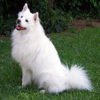

In [ ]:
from torchvision import models
from PIL import Image
import io
from urllib.request import urlopen
from torchvision import datasets, transforms

model = models.resnet34(pretrained=True)

model.eval()

x = Image.open(io.BytesIO(urlopen("https://github.com/pytorch/hub/raw/master/images/dog.jpg").read()))

preprocess = transforms.Compose([transforms.Resize(256),
                                 transforms.CenterCrop(224),
                                 transforms.ToTensor(),
                                 transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),])

x_batch = preprocess(x).unsqueeze(0) # 1xHxW

# model.to(device)
# x_batch = x_batch.to(device)

with torch.no_grad():
    output = model(x_batch)

probabilities = torch.nn.functional.softmax(output[0], dim=0)

x.resize((100, 100)) # вывести в уменьшенном виде

In [ ]:
import requests

categories = [s.strip() for s in requests.get(
    'https://raw.githubusercontent.com/pytorch/hub/master/imagenet_classes.txt').text.split('\n')]

top_prob, top_catid = torch.topk(probabilities, 5)

for p, c in zip(top_prob, top_catid):
    print (categories[c], np.round(p.item(), 3))

Samoyed 0.884
Pomeranian 0.039
Arctic fox 0.026
keeshond 0.024
white wolf 0.005


# BiLSTM

In [ ]:
class BiLSTM(nn.Module): # модуль - удобная сущность с параметрами
    def __init__(self):
        super().__init__()
        self.hidden_size = 64
        drp = 0.1
        max_features, embed_size = 10000,300
        self.embedding = nn.Embedding(max_features, embed_size)
        self.lstm = nn.LSTM(embed_size, self.hidden_size, bidirectional=True, batch_first=True)
        self.linear = nn.Linear(self.hidden_size*4 , 64)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(drp)
        self.out = nn.Linear(64, 1)


    def forward(self, x):
        h_embedding = self.embedding(x)
        h_embedding = torch.squeeze(torch.unsqueeze(h_embedding, 0))

        h_lstm, _ = self.lstm(h_embedding)
        avg_pool = torch.mean(h_lstm, 1)
        max_pool, _ = torch.max(h_lstm, 1)
        conc = torch.cat(( avg_pool, max_pool), 1)
        conc = self.relu(self.linear(conc))
        conc = self.dropout(conc)
        out = self.out(conc)
        return out

## Как сеть искриволяет пространство

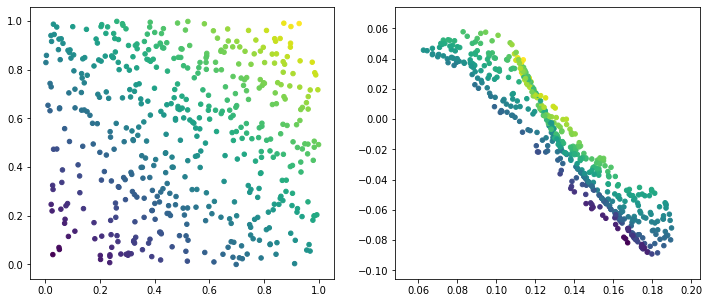

In [ ]:
import torch.nn as nn

X = torch.rand(500, 2)
y = X[:, 0] + X[:, 1]
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.scatter(X[:,0], X[:,1], 20, y)

n_hidden = 10
model = nn.Sequential(nn.Linear(2, n_hidden),
                      nn.ReLU(),
                      nn.Linear(n_hidden, n_hidden),
                      nn.ReLU(),
                      nn.Linear(n_hidden, 2))
# model.to(device)
with torch.no_grad():
    Y = model(X)
plt.subplot(1, 2, 2)
plt.scatter(Y[:,0], Y[:,1], 20, y)

## Пример

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

import random, math
seed = 12345
random.seed(seed)
torch.manual_seed(seed)
N = 1000  # num_samples_per_class
D = 2  # dimensions
C = 3  # num_classes
H = 100  # num_hidden_units

# данные
X = torch.zeros(N * C, D).to(device)
y = torch.zeros(N * C, dtype=torch.long).to(device)
for c in range(C):
    index = 0
    t = torch.linspace(0, 1, N)

    inner_var = torch.linspace((2 * math.pi / C) * (c), (2 * math.pi / C) * (2 + c), N) + torch.randn(N) * 0.2

    for ix in range(N * c, N * (c + 1)):
        X[ix] = t[index] * torch.FloatTensor((math.sin(inner_var[index]), math.cos(inner_var[index])))
        y[ix] = c
        index += 1

print("Shapes:")
print("X:", tuple(X.size()))
print("y:", tuple(y.size()))

Shapes:
X: (3000, 2)
y: (3000,)


In [ ]:
from IPython import display
learning_rate = 1e-3
lambda_l2 = 1e-5

model = nn.Sequential(
    nn.Linear(D, H),
    nn.ReLU(),
    nn.Linear(H, C)
)
model.to(device)

criterion = torch.nn.CrossEntropyLoss()

optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=lambda_l2)

for t in range(1000):

    y_pred = model(X)

    loss = criterion(y_pred, y)
    score, predicted = torch.max(y_pred, 1)
    acc = (y == predicted).sum().float() / len(y)
    print("[EPOCH]: %i, [LOSS]: %.6f, [ACCURACY]: %.3f" % (t, loss.item(), acc))
    display.clear_output(wait=True)

    optimizer.zero_grad()

    loss.backward()

    optimizer.step()

[EPOCH]: 999, [LOSS]: 0.161706, [ACCURACY]: 0.954


Sequential(
  (0): Linear(in_features=2, out_features=100, bias=True)
  (1): ReLU()
  (2): Linear(in_features=100, out_features=3, bias=True)
)


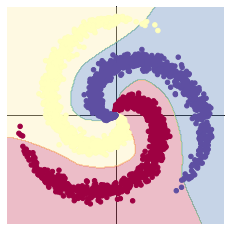

In [ ]:
print(model)
plot_model(X, y, model)

### НС на numpy

дальше примеры из https://pytorch.org/tutorials/beginner/pytorch_with_examples.html

In [ ]:
%%time

import numpy as np

# N is batch size; D_in is input dimension;
# H is hidden dimension; D_out is output dimension.
N, D_in, H, D_out = 64, 1000, 100, 10

# Create random input and output data
x = np.random.randn(N, D_in)
y = np.random.randn(N, D_out)

# Randomly initialize weights
w1 = np.random.randn(D_in, H)
w2 = np.random.randn(H, D_out)

learning_rate = 1e-6
for t in range(5000):
    # Forward pass: compute predicted y
    h = x.dot(w1)
    h_relu = np.maximum(h, 0)
    y_pred = h_relu.dot(w2)

    # Compute and print loss
    loss = np.square(y_pred - y).sum()
    # print(t, loss)

    # Backprop to compute gradients of w1 and w2 with respect to loss
    grad_y_pred = 2.0 * (y_pred - y)
    grad_w2 = h_relu.T.dot(grad_y_pred)
    grad_h_relu = grad_y_pred.dot(w2.T)
    grad_h = grad_h_relu.copy()
    grad_h[h < 0] = 0
    grad_w1 = x.T.dot(grad_h)

    # Update weights
    w1 -= learning_rate * grad_w1
    w2 -= learning_rate * grad_w2

print(loss)

1.74824768139619e-24
Wall time: 2.55 s


In [ ]:
%%time

import torch


dtype = torch.float
# device = torch.device("cpu")
device = torch.device("cuda:0") # Uncomment this to run on GPU

# N is batch size; D_in is input dimension;
# H is hidden dimension; D_out is output dimension.
N, D_in, H, D_out = 64, 1000, 100, 10

# Create random input and output data
x = torch.randn(N, D_in, device=device, dtype=dtype)
y = torch.randn(N, D_out, device=device, dtype=dtype)

# Randomly initialize weights
w1 = torch.randn(D_in, H, device=device, dtype=dtype)
w2 = torch.randn(H, D_out, device=device, dtype=dtype)

learning_rate = 1e-6
for t in range(5000):
    # Forward pass: compute predicted y
    h = x.mm(w1)
    h_relu = h.clamp(min=0)
    y_pred = h_relu.mm(w2)

    # Compute and print loss
    loss = (y_pred - y).pow(2).sum().item()
    #if t % 100 == 99:
    #   print(t, loss)

    # Backprop to compute gradients of w1 and w2 with respect to loss
    grad_y_pred = 2.0 * (y_pred - y)
    grad_w2 = h_relu.t().mm(grad_y_pred)
    grad_h_relu = grad_y_pred.mm(w2.t())
    grad_h = grad_h_relu.clone()
    grad_h[h < 0] = 0
    grad_w1 = x.t().mm(grad_h)

    # Update weights using gradient descent
    w1 -= learning_rate * grad_w1
    w2 -= learning_rate * grad_w2

print(loss)
# CPU 3.05 s
# GPU 6.77 s

2.74573608294304e-07
Wall time: 7.42 s


In [ ]:
%%time

import torch

dtype = torch.float
# device = torch.device("cpu")
device = torch.device("cuda:0") # Uncomment this to run on GPU

# N is batch size; D_in is input dimension;
# H is hidden dimension; D_out is output dimension.
N, D_in, H, D_out = 64, 1000, 100, 10

# Create random Tensors to hold input and outputs.
# Setting requires_grad=False indicates that we do not need to compute gradients
# with respect to these Tensors during the backward pass.
x = torch.randn(N, D_in, device=device, dtype=dtype)
y = torch.randn(N, D_out, device=device, dtype=dtype)

# Create random Tensors for weights.
# Setting requires_grad=True indicates that we want to compute gradients with
# respect to these Tensors during the backward pass.
w1 = torch.randn(D_in, H, device=device, dtype=dtype, requires_grad=True)
w2 = torch.randn(H, D_out, device=device, dtype=dtype, requires_grad=True)

learning_rate = 1e-6
for t in range(5000):
    # Forward pass: compute predicted y using operations on Tensors; these
    # are exactly the same operations we used to compute the forward pass using
    # Tensors, but we do not need to keep references to intermediate values since
    # we are not implementing the backward pass by hand.
    y_pred = x.mm(w1).clamp(min=0).mm(w2)

    # Compute and print loss using operations on Tensors.
    # Now loss is a Tensor of shape (1,)
    # loss.item() gets the scalar value held in the loss.
    loss = (y_pred - y).pow(2).sum()
    #if t % 100 == 99:
    #    print(t, loss.item())

    # Use autograd to compute the backward pass. This call will compute the
    # gradient of loss with respect to all Tensors with requires_grad=True.
    # After this call w1.grad and w2.grad will be Tensors holding the gradient
    # of the loss with respect to w1 and w2 respectively.
    loss.backward()

    # Manually update weights using gradient descent. Wrap in torch.no_grad()
    # because weights have requires_grad=True, but we don't need to track this
    # in autograd.
    # An alternative way is to operate on weight.data and weight.grad.data.
    # Recall that tensor.data gives a tensor that shares the storage with
    # tensor, but doesn't track history.
    # You can also use torch.optim.SGD to achieve this.
    with torch.no_grad():
        w1 -= learning_rate * w1.grad
        w2 -= learning_rate * w2.grad

        # Manually zero the gradients after updating weights
        w1.grad.zero_()
        w2.grad.zero_()

print (loss.item())

# CPU 5.7 s
# GPU 8.87 s

3.4651128544282983e-07
Wall time: 7.52 s


# Пример пакета nn

In [ ]:
%%time

import torch

# N is batch size; D_in is input dimension;
# H is hidden dimension; D_out is output dimension.
N, D_in, H, D_out = 64, 1000, 100, 10

# Create random Tensors to hold inputs and outputs
x = torch.randn(N, D_in)
y = torch.randn(N, D_out)

# Use the nn package to define our model as a sequence of layers. nn.Sequential
# is a Module which contains other Modules, and applies them in sequence to
# produce its output. Each Linear Module computes output from input using a
# linear function, and holds internal Tensors for its weight and bias.
model = torch.nn.Sequential(
    torch.nn.Linear(D_in, H),
    torch.nn.ReLU(),
    torch.nn.Linear(H, D_out),
)

# The nn package also contains definitions of popular loss functions; in this
# case we will use Mean Squared Error (MSE) as our loss function.
loss_fn = torch.nn.MSELoss(reduction='sum')

learning_rate = 1e-4
for t in range(5000):
    # Forward pass: compute predicted y by passing x to the model. Module objects
    # override the __call__ operator so you can call them like functions. When
    # doing so you pass a Tensor of input data to the Module and it produces
    # a Tensor of output data.
    y_pred = model(x)

    # Compute and print loss. We pass Tensors containing the predicted and true
    # values of y, and the loss function returns a Tensor containing the
    # loss.
    loss = loss_fn(y_pred, y)
    #if t % 100 == 99:
    #    print(t, loss.item())

    # Zero the gradients before running the backward pass.
    model.zero_grad()

    # Backward pass: compute gradient of the loss with respect to all the learnable
    # parameters of the model. Internally, the parameters of each Module are stored
    # in Tensors with requires_grad=True, so this call will compute gradients for
    # all learnable parameters in the model.
    loss.backward()

    # Update the weights using gradient descent. Each parameter is a Tensor, so
    # we can access its gradients like we did before.
    with torch.no_grad():
        for param in model.parameters():
            param -= learning_rate * param.grad

print(loss.item())
# CPU 8.05 s

1.0499554350951179e-11
Wall time: 7.21 s


In [ ]:
%%time

import torch

N, D_in, H, D_out = 64, 1000, 100, 10

x = torch.randn(N, D_in)
y = torch.randn(N, D_out)

model = torch.nn.Sequential(
    torch.nn.Linear(D_in, H),
    torch.nn.ReLU(),
    torch.nn.Linear(H, D_out),
)

loss_fn = torch.nn.MSELoss(reduction='sum')


learning_rate = 1e-4
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

for t in range(5000):
    y_pred = model(x)

    loss = loss_fn(y_pred, y)
    # if t % 100 == 99:
    #     print(t, loss.item())

    optimizer.zero_grad()

    loss.backward()

    optimizer.step()

print(loss.item())

1.0213095993916177e-11
Wall time: 10.3 s


## отдельные Log-регрессии и одна многомерная

* отдельные - очень медленно на 1 GPU

In [ ]:
class MyOneModel(nn.Module):
    def __init__(self, in_features, out_features):
        super(MyOneModel, self).__init__()
        self.bn1 = nn.BatchNorm1d(in_features)
        self.do1 = nn.Dropout(0.3)
        self.ln1 = nn.Linear(in_features, out_features) # nn.utils.weight_norm(nn.Linear(n1, n2))
        self.ph1 = nn.Sigmoid()

    def forward(self, x):
        z = self.ph1(self.ln1(self.do1(self.bn1(x)))) #
        return z

class MyModel(nn.Module):
    def __init__(self, in_features, out_features):
        super(MyModel, self).__init__()
        # self.out_features = out_features
        self.mymodules = nn.ModuleList([MyOneModel(in_features, 1) for _ in range(out_features)])
        # self.parameters = nn.ParameterList([f.parameters for f in self.mymodules])

    def forward(self, x):
        z = torch.cat([f(x) for f in self.mymodules], axis=1)
        # print(z.size(), self.mymodules[0](x).size())
        return z

# Что ещё

Хорошие советы по оптимизации:
    * https://pytorch.org/tutorials/recipes/recipes/tuning_guide.html